In [5]:
from Graph import AdjacencyGraph
from GeneticAlgo import GA
import networkx
import numpy as np
from itertools import product
from tqdm import tqdm
import pickle
import multiprocess
import psutil
from pprint import pprint
from copy import deepcopy
from matplotlib import pyplot as plt
from datetime import timedelta 


# ======================================================================================
#e = networkx.petersen_graph().edges
# best obtained is 125.4 k=3 
# optimal solution is 125.4 k=3
# ======================================================================================
#e = networkx.dorogovtsev_goltsev_mendes_graph(3).edges 
# best obtained is 190.39 k=4
# optimal solution is 189.5, k=3
# ======================================================================================
e = networkx.desargues_graph().edges 
# best obtained is 243.1 k=3
# it is a bipartite graph, so optimal solution is 239, k=2
# ======================================================================================

g = AdjacencyGraph(e)

cost_map = {
    0: 11.7,
    1: 12.2,
    2: 14,
    3: 14.1,
    4: 14.7,
    5: 15.0,
    6: 21.1,
    7: 23.1,
    8: 43.1,
    9: 43.2,
} | {
    c: 100 for c in range(10, 21)
}

print(g.summary(cost_map=cost_map))

20-colored graph;Proper coloring (No violations); With cost 1212.600


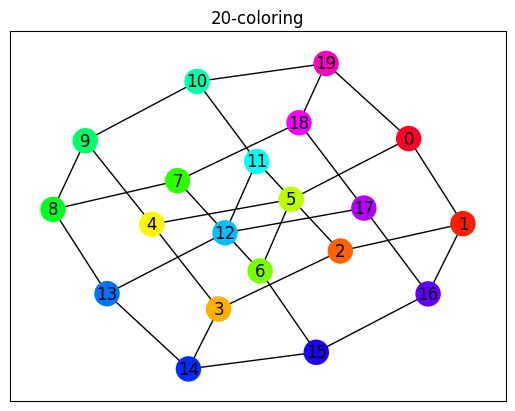

In [6]:
g.plot()
plt.show()

In [7]:
def grid_search_explore_parameters(
        g,
        cost_map,
        iter_limit,
        fname,
        folds = 1,
        mp_threads = max(psutil.cpu_count() - 1, 1),
        symetrical_crossing_offspring_l = [10],
        graph_mutate_chance_l = np.arange(0.3, 0.9, 0.2),
        introduce_n_random_individuals_l = range(1_000, 2_001, 500),
        least_fitting_prune_enabled_l = [True, False],
        least_fitting_prune_ratio_l = np.arange(0.2, 0.6, 0.2),
        randomness_survival_pruning_enabled_l = [True, False],
        randomness_survival_chance_l = np.arange(0.2, 0.5, 0.2),
        scheduled_pruning_enabled_l = [False],
        print_enabled = False,
        deadline = None
        ):


    grid = list(product(
        symetrical_crossing_offspring_l,
        graph_mutate_chance_l,
        introduce_n_random_individuals_l,
        least_fitting_prune_enabled_l,
        least_fitting_prune_ratio_l,
        randomness_survival_pruning_enabled_l,
        randomness_survival_chance_l,
        scheduled_pruning_enabled_l
    ))

    print(f'Starting grid search for total of {len(grid)} combinations and {folds} folds...')

    grid_results = {}


    def do_gs_execution(args):
        
        (
            symetrical_crossing_offspring,
            graph_mutate_chance,
            introduce_n_random_individuals,
            least_fitting_prune_enabled,
            least_fitting_prune_ratio,
            randomness_survival_pruning_enabled,
            randomness_survival_chance,
            scheduled_pruning
        ) = args

        if least_fitting_prune_enabled == randomness_survival_pruning_enabled and (not least_fitting_prune_enabled):
            # invalid configuration
            print('Invalid configuration -- skipping')
            return (float('inf'), 0)

        g_local = deepcopy(g)
        coloring_cost = []
        for i in range(folds):
            coloring, _history = GA(
                g_local,
                cost_map,
                iter_limit,
                initial_population_size=5_000,
                symetrical_crossing_offspring=symetrical_crossing_offspring,
                graph_mutate_chance=graph_mutate_chance,
                introduce_n_random_individuals=introduce_n_random_individuals,
                least_fitting_prune_enabled=least_fitting_prune_enabled,
                least_fitting_prune_ratio=least_fitting_prune_ratio,
                randomness_survival_pruning_enabled=randomness_survival_pruning_enabled,
                randomness_survival_chance=randomness_survival_chance,
                scheduled_pruning=scheduled_pruning,
                patience=None,
                print_enabled=print_enabled,
                deadline=deadline/folds
            )

            coloring_cost.append( g_local.apply_coloring(coloring).coloring_cost(cost_map) )
            print(f'Finished fold {i} with args: {args}')
        
        print(f'Finished configuration with args: {args}')
        return (coloring_cost, np.std(coloring_cost))

    
    if mp_threads > 1:
        print(f'Starting Multiprocess GridSearch with {mp_threads} threads')
    with multiprocess.Pool(mp_threads) as p:

        res = p.map(do_gs_execution, grid)


    grid_results = {str(gs_args) : r for (gs_args, r) in zip(grid, res)}

        
    with open(fname, 'wb') as f:
        pickle.dump(grid_results, f)


    return grid_results



In [8]:
gs_results = grid_search_explore_parameters(
    g,
    cost_map,
    5_000,
    'desargues_GA_gs_results_240sec-2fold.pickle',
    print_enabled=False,
    deadline_s=timedelta(minutes=30),
    folds=2
)

pprint(gs_results)

Starting grid search for total of 192 combinations and 2 folds...
Starting Multiprocess GridSearch with 9 threads
Invalid configuration -- skippingInvalid configuration -- skipping

Invalid configuration -- skippingInvalid configuration -- skipping

Finished fold 0 with args: (10, 0.5, 1000, True, 0.2, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 1500, False, 0.2, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 1000, True, 0.2, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 2000, True, 0.4, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 1000, False, 0.4, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 2000, True, 0.2, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 2000, False, 0.4, True, 0.2, False)
Finished fold 0 with args: (10, 0.3, 1500, True, 0.2, False, 0.2, False)
Finished fold 0 with args: (10, 0.3, 1000, True, 0.4, False, 0.2, False)
Finished fold 1 with args: (10, 0.5, 1000, True, 0.2, True, 0.2, False)
Finished configuration wi

In [15]:
srt = list(
    sorted(
        list(
            zip(gs_results.keys(), gs_results.values())
        ),
        key=lambda tpl: np.mean(tpl[1][0]),    
    )
)

for (conf, (results, std)) in srt[:10]:
    print(f'Conf: {conf}: mean result: {np.mean(results):.3f} ({std:.3f} std) ({results})')

Conf: (10, 0.9000000000000001, 2000, False, 0.4, True, 0.2, False): mean result: 251.300 (1.600 std) ([249.69999999999993, 252.89999999999992])
Conf: (10, 0.3, 2000, False, 0.4, True, 0.2, False): mean result: 252.400 (0.300 std) ([252.0999999999999, 252.6999999999999])
Conf: (10, 0.7, 2000, False, 0.4, True, 0.2, False): mean result: 252.450 (2.650 std) ([249.79999999999993, 255.09999999999994])
Conf: (10, 0.9000000000000001, 1500, True, 0.4, True, 0.2, False): mean result: 253.250 (0.950 std) ([252.29999999999993, 254.19999999999993])
Conf: (10, 0.5, 1000, True, 0.2, True, 0.4, False): mean result: 253.400 (2.300 std) ([251.0999999999999, 255.6999999999999])
Conf: (10, 0.5, 1000, True, 0.4, True, 0.4, False): mean result: 253.450 (0.350 std) ([253.79999999999995, 253.0999999999999])
Conf: (10, 0.9000000000000001, 2000, True, 0.4, True, 0.4, False): mean result: 253.550 (3.750 std) ([257.29999999999995, 249.79999999999993])
Conf: (10, 0.7, 1000, True, 0.2, True, 0.2, False): mean resu